In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


## Prepare Dataset

In [3]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

train_dataset_path = './dataset/train_preprocess_no_stemming.csv'
valid_dataset_path = './dataset/valid_preprocess_no_stemming.csv'

In [4]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)

train_df.columns = ['label', 'tweet_tokens_no_stemming']
valid_df.columns = ['label', 'tweet_tokens_no_stemming']

In [5]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'dimiliki', 'pengusaha', 'pabrik', ..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,negative,"['duh', 'mahasiswa', 'jangan-jangan', 'sombong..."
5,positive,"['makanan', 'beragam', 'harga', 'makanan', 'fo..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak', ..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makanan', 'ena..."
8,positive,"['keluarga', 'menikmati', 'pengalaman', 'kulin..."
9,positive,['bersyukur']


In [6]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'dimiliki', 'pengusaha', 'pabrik', ..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,negative,"['duh', 'mahasiswa', 'jangan-jangan', 'sombong..."
5,positive,"['makanan', 'beragam', 'harga', 'makanan', 'fo..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak', ..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makanan', 'ena..."
8,positive,"['keluarga', 'menikmati', 'pengalaman', 'kulin..."
9,positive,['bersyukur']


In [7]:
def get_label_idx(label):
    if label == 'positive':
        return 2
    if label == 'negative':
        return 1
    if label == 'neutral':
        return 0
train_df['label'] = train_df['label'].apply(get_label_idx)
valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [8]:
train_df

,label,tweet_tokens_no_stemming
0,2,"['warung', 'dimiliki', 'pengusaha', 'pabrik', ..."
1,0,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,2,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,2,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,1,"['duh', 'mahasiswa', 'jangan-jangan', 'sombong..."
...,...,...
10996,2,"['enak', 'masakan', 'kepiting', 'menyenangkan'..."
10997,0,"['hormati', 'partaipartai', 'berkoalisi']"
10998,1,"['pagi', 'pagi', 'tol', 'pasteur', 'macet', 'p..."
10999,2,"['belanja', 'yogya', 'riau', 'junction', 'kali..."


In [9]:
jumlah_positives = (train_df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (train_df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 6417
Jumlah review negatif: 3436


In [10]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet_tokens_no_stemming"].apply(join_text_list)
valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

0    warung dimiliki pengusaha pabrik puluhan tahun...
1    mohon ulama lurus mmbri hujjah partai apa-apa ...
2    lokasi strategis jalan sumatera bandung nyaman...
3    betapa bahagia unboxing paket barang bagus men...
4    duh mahasiswa jangan-jangan sombong kasih kart...
Name: preprocessed, dtype: object

In [11]:
# Filter DataFrame untuk label 1 dan 2
df_train_filtered = train_df[train_df['label'].isin([1, 2])]
df_valid_filtered = valid_df[valid_df['label'].isin([1, 2])]

# Perbarui label sehingga label 1 menjadi 0 dan label 2 menjadi 1
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map({1: 0, 2: 1})
df_valid_filtered.loc[:, 'label'] = df_valid_filtered['label'].map({1: 0, 2: 1})


# Split dataset menjadi fitur (X) dan label (y)
X_train = df_train_filtered['preprocessed']
y_train = df_train_filtered['label']

X_valid = df_valid_filtered['preprocessed']
y_valid = df_valid_filtered['label']

In [12]:
## hitung jumlah positive dan negative
jumlah_positives = (y_train == 1).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_train == 0).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

jumlah_positives = (y_valid == 1).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_valid == 0).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 6417
Jumlah review negatif: 3436
Jumlah review positif: 735
Jumlah review negatif: 394


## Generate Padded Sequence

In [13]:
# Parameters

vocab_size = 20000 #ukuran kosakata yang akan digunakan
max_length = 100 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [14]:
## Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)


all_texts = list(X_train) + list(X_valid)

# Generate word index dictionary for the training sentences
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
print(word_index)

# Convert the training sentences into word sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# Convert the validation sentences into word sequences
valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)

{'<OOV>': 1, 'tidak': 2, 'makanan': 3, 'enak': 4, 'makan': 5, 'harga': 6, 'bandung': 7, 'menu': 8, 'banget': 9, 'orang': 10, 'restoran': 11, 'suasana': 12, 'nyaman': 13, 'malam': 14, 'besar': 15, 'ayam': 16, 'pelayanan': 17, 'goreng': 18, 'nasi': 19, 'bagus': 20, 'pemandangan': 21, 'jalan': 22, 'suka': 23, 'mahal': 24, 'jangan': 25, 'lumayan': 26, 'apa': 27, 'anak': 28, 'pilihan': 29, 'cocok': 30, 'keluarga': 31, 'kecil': 32, 'lokasi': 33, 'resto': 34, 'kota': 35, 'pas': 36, 'porsi': 37, 'tahun': 38, 'salah': 39, 'steak': 40, 'pesan': 41, 'sunda': 42, 'deh': 43, 'minuman': 44, 'khas': 45, 'masakan': 46, 'kafe': 47, 'kali': 48, 'murah': 49, 'teman': 50, 'mi': 51, 'rumah': 52, 'indonesia': 53, 'dingin': 54, 'favorit': 55, 'menikmati': 56, 'oke': 57, 'bakso': 58, 'ramai': 59, 'mantap': 60, 'ramah': 61, 'terjangkau': 62, 'mencoba': 63, 'nama': 64, 'sambal': 65, 'daging': 66, 'bakar': 67, 'coba': 68, 'jam': 69, 'siang': 70, 'luas': 71, 'masuk': 72, 'batagor': 73, 'cepat': 74, 'memesan': 75,

In [15]:
# import pickle

# Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:
print(train_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  128 1921 3780 3305 1182   38
   38  129  372    7  519 1314 7903 1256 1314 7904  128  181    8  262
 1922  137    8   16  203   53    6   62   25   25 2642 7905    2  313
  268 7906]


## Word Embedding

In [17]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [18]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [19]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.08408654,  0.17551568, -0.83917415, ..., -0.49701187,
         2.59039712,  0.08432699],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[101])
print(word)

('meja', array([-3.05764127, -1.20848596,  0.13670197,  0.36120418,  0.40277165,
       -1.18649995,  1.97927642, -0.40663478]))


## Build and Compile Model

In [21]:
# convert to bi-lstm model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 8)            │    160,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)          │    140,288 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)               │    164,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 16)                │      2,064 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 466,721 (1.78 MB)

 Trainable params: 466,721 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding
Weights Shape (Tensor 0): (20000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.0840865   0.17551568 -0.83917415 ... -0.49701187  2.5903971
   0.08432699]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: bidirectional
Weights Shape (Tensor 0): (8, 512)
Weights (Tensor 0):
[[-0.00052593 -0.04275201  0.03523608 ...  0.0771687  -0.06620215
  -0.09602159]
 [-0.00505465 -0.00334529  0.05613745 ...  0.10354448 -0.07113123
   0.00204342]
 [ 0.03664974  0.00210537  0.01403788 ... -0.04585559 -0.0808242
  -0.02956492]
 ...
 [-0.00810542  0.02239559  0.04910538 ...  0.08396981 -0.03491014
  -0.0572036 ]
 [ 0.05436803  0.04986753  0.04715214 ... -0.04854331  0.0819

## Train Model

In [23]:
num_epochs = 6

history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(valid_padded, y_valid), verbose=2)


Epoch 1/6
308/308 - 159s - 516ms/step - accuracy: 0.8345 - loss: 0.4254 - val_accuracy: 0.8618 - val_loss: 0.3614
Epoch 2/6
308/308 - 191s - 621ms/step - accuracy: 0.8612 - loss: 0.3619 - val_accuracy: 0.8804 - val_loss: 0.3391
Epoch 3/6
308/308 - 173s - 562ms/step - accuracy: 0.8844 - loss: 0.3025 - val_accuracy: 0.8973 - val_loss: 0.2762
Epoch 4/6
308/308 - 198s - 643ms/step - accuracy: 0.9120 - loss: 0.2405 - val_accuracy: 0.9167 - val_loss: 0.2273
Epoch 5/6
308/308 - 147s - 478ms/step - accuracy: 0.9302 - loss: 0.1855 - val_accuracy: 0.9132 - val_loss: 0.2328
Epoch 6/6
308/308 - 183s - 595ms/step - accuracy: 0.9440 - loss: 0.1595 - val_accuracy: 0.9123 - val_loss: 0.2432


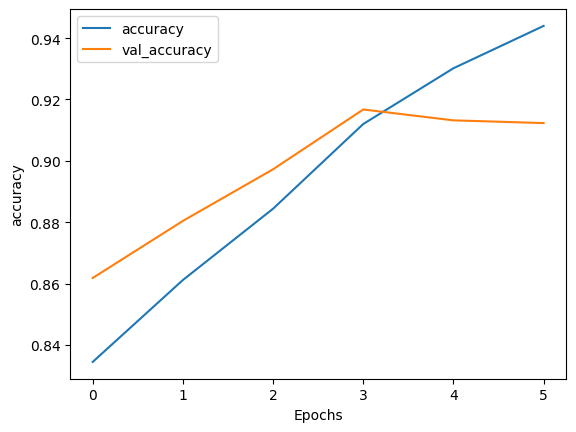

In [29]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

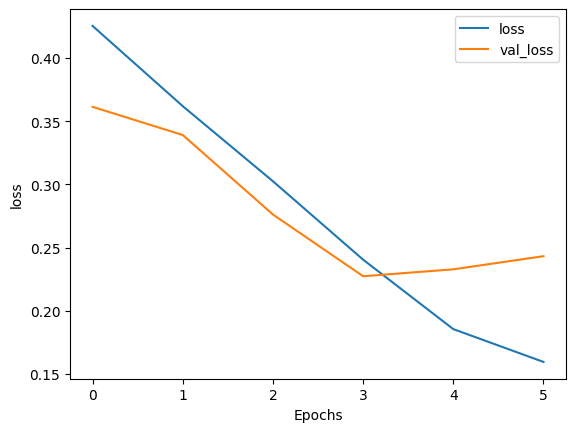

In [30]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [31]:
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type)
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Menggunakan fungsi untuk memprediksi sentimen dari contoh kalimat
sample_text = "Meskipun awalnya saya tidak suka film ini karena plotnya terasa lambat, setelah menontonnya hingga akhir, saya benar-benar terkesan dengan alur ceritanya yang mendalam dan perkembangan karakternya yang luar biasa."
predicted_label = predict_sentiment(model, tokenizer, sample_text)
print("Label Sentimen:", predicted_label)
   


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[0.30756995]]
Label Sentimen: Negatif


In [32]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = (y_pred >= 0.5).astype(int)

# Mencetak classification report
print(classification_report(df_valid_filtered["label"], y_pred_classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       394
           1       0.93      0.93      0.93       735

    accuracy                           0.91      1129
   macro avg       0.90      0.90      0.90      1129
weighted avg       0.91      0.91      0.91      1129



In [28]:
#save model
# model.save('./model/model-bilstm.hdf5')